<hr/>

# CUFSM

- For general signature curve analysis

<hr/>

[Open In Colab](https://colab.research.google.com/github/joelbenjohn/pyCUFSM/blob/master/Jupyter_Notebooks/pyCUFSM.ipynb)

## Clone Github and Import packages

In [ ]:
!rm -rf /content/pyCUFSM
!git clone https://github.com/ClearCals/pyCUFSM
import sys
sys.path.insert(1, '/content/pyCUFSM')
import numpy as np
import matplotlib.pyplot as plt
from pycufsm.fsm import strip
from pycufsm.preprocess import stress_gen
from pycufsm.preprocess import yieldMP
from pycufsm.preprocess import doubler
import pycufsm.plotters as plotters
import cutwp_prop2

## Pre Processor
### Cross Section

In [7]:
# Define an isotropic material
#props = [material#, Ex, Ey, vx, vy, G]
props = np.array([
    [0, 29500, 29500, 0.3, 0.3, 29500 / (2 * (1 + 0.3))]
])

# Nodal location units are inches
#nodes = [node#, x, y, xdof, zdof, ydof, qdof, stress]
nodes = np.array([
    [0, 2.5, 0.773, 1, 1, 1, 1, 0],
    [1, 2.5, 0, 1, 1, 1, 1, 0],
    [2, 1.25, 0, 1, 1, 1, 1, 0],
    [3, 0, 0, 1, 1, 1, 1, 0],
    [4, 0, 3, 1, 1, 1, 1, 0],
    [5, 0, 6, 1, 1, 1, 1, 0],
    [6, 0, 9, 1, 1, 1, 1, 0],
    [7, 1.25, 9, 1, 1, 1, 1, 0],
    [8, 2.5, 9, 1, 1, 1, 1, 0],
    [9, 2.5, 8.227, 1, 1, 1, 1, 0]
])
#elements = [elem#, nodei, nodej, thickness, material#]
elements = np.array([
    [0, 0, 1, 0.059, 0],
    [1, 1, 2, 0.059, 0],
    [2, 2, 3, 0.059, 0],
    [3, 3, 4, 0.059, 0],
    [4, 4, 5, 0.059, 0],
    [5, 5, 6, 0.059, 0],
    [6, 6, 7, 0.059, 0],
    [7, 7, 8, 0.059, 0],
    [8, 8, 9, 0.059, 0]
])

# Springs = []
springs = []

#Constraints = []
constraints = []

#Doubler
nodes, elements = doubler(nodes, elements)
flag = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
plotters.crossect(nodes, elements, springs, constraints,flag)
plt.show()

NameError: name 'doubler' is not defined

### Lengths
   >- To generate $n$ lengths equally spaced between $a$ and $b$ use **lengths = np.linspace(a, b, n)**
   >- To generate $n$ lengths log spaced between $10^a$ and $10^b$ use **lengths = np.linspace(a, b, n)**

In [6]:
# These lengths will generally provide sufficient accuracy for local, distortional, and global buckling modes
lengths = np.array([
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160,
    170, 180, 190, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900,
    1000, 1100, 1200, 1300, 1400, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
    5000, 6000, 7000, 8000, 9000, 10000
])

### Boundary Condition Selection

| Boundary Condition | Key |
| :--- | ----------- |
| Simple-Simple | 'S-S' |
| Clamped-Clamped |'C-C' |
| Simple-Clamped |'S-C' |
| Clamped-Free |'C-F' |
| Clamped-Guided |'C-G' |

In [ ]:
# Boundary Condition
b_c = 'S-S'

# For signature curve analysis, only a single array of ones makes sense here
m_all = np.ones((len(lengths), 1))

# Number of eigenvalues
n_eigs = 10

### Applied Stress Generator

In [ ]:
# Calculate Section Properties
sect_props = cutwp_prop2.cutwp_prop2(nodes[:, 1:3], elements[:, 1:4])

# Yield Strength
fy = 50

# To do a restrained bending calculation
Restrained = False

# Generate the yield strength
Fyield = yieldMP(nodes, fy, sect_props, restrained)
# Generate stress points
nodes_p = stress_gen(nodes=nodes,
                     forces={
                         'P': Fyield['P']*0,
                         'Mxx': Fyield['Mxx']*1,
                         'Myy': Fyield['Myy']*0,
                         'M11': Fyield['M11']*0,
                         'M22': Fyield['M22']*0
                     },
                     sect_props=sect_props,
                     restrained=restrained,
                    )

##CALL CROSS SECTION
#Flag = {node, elem, mat, stress, stresspic, coord, constraints, springs, origin, propaxis}
flag = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
plotters.crossect(nodes_p, elements, springs, constraints,flag)
plt.show()

# Analysis

In [8]:
# Values here correspond to signature curve basis and orthogonal based upon geometry
gbt_con = {
    'glob': [0],
    'dist': [0],
    'local': [0],
    'other': [0],
    'o_space': 1,
    'couple': 1,
    'orth': 2,
    'norm': 0,
}
# Perform the Finite Strip Method analysis
signature, curve, shapes = strip(props=props,
                                 nodes=nodes_p,
                                 elements=elements,
                                 lengths=lengths,
                                 springs=springs,
                                 constraints=constraints,
                                 gbt_con=gbt_con,
                                 b_c=b_c,
                                 m_all=m_all,
                                 n_eigs=n_eigs,
                                 sect_props=sect_props)
signature = np.array(signature)
curves = np.array(curve)
shapes = np.array(shapes)
curve = np.zeros(((len(lengths),n_eigs,2)))
for j in range(len(lengths)):
    for i in range(n_eigs):
        curve[j, i, 0] = lengths[j]
        curve[j, i, 1] = curves[j, i]
fileindex = 1
fileddisplay = [1]
clas = 0
clasopt = 0

# Post Processing
## Signature Curve

In [ ]:
####SIGNATURE CURVE####
###Buckling halfwavelenth plot from a signature analysis
minopt = 1
logopt = 1

#plot limits
xmin = np.min(lengths)*10/11
xmax = np.max(lengths)*11/10
ymin = 0
ymax = np.min([np.max(signature), 3*np.median(signature)])

#Modes to display
modedisplay = [1]

#Interested point
modeindex = 1
length_index = 40
picpoint = [lengths[length_index-1], curves[length_index-1, modeindex-1]]

#CALL THE CURVE
plotters.thecurve3(curve, clas, fileddisplay, minopt, logopt, clasopt, xmin, xmax, ymin, ymax, modedisplay, fileindex, modeindex, picpoint)

## Displaced Shape

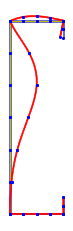

In [9]:
######POST PROCESSING#########
modeindex = 1
length_index = 20
scale = 5
x = plotters.dispshap(1, nodes, elements, shapes[length_index-1, :, modeindex-1], scale, springs, [1], b_c , 1/2)